<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
<br>汉化的库: <a href="https://github.com/GoatCsu/CN-LLMs-from-scratch.git">https://github.com/GoatCsu/CN-LLMs-from-scratch.git</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="../image/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第 6 章：进行文本分类的微调

In [1]:
# 从 importlib.metadata 模块导入 version 函数
# 该函数用于获取已安装 Python 包的版本信息
from importlib.metadata import version

# 定义一个包含本章所需依赖包名称的列表
pkgs = ["matplotlib",  # 用于数据可视化和绘图的库
        "numpy",       # 用于数值计算和数组操作的基础库
        "tiktoken",    # OpenAI 的分词器库,用于将文本转换为 token
        "torch",       # PyTorch 深度学习框架,用于构建和训练神经网络
        "tensorflow",  # 用于加载OpenAI的预训练权重的TensorFlow库
        "pandas"       # 用于加载数据集的库,提供数据处理和分析功能
       ]

# 遍历包列表,逐个打印每个包的版本号
for p in pkgs:
    # 使用 f-string 格式化输出:包名 + 版本号
    # version(p) 会查询已安装包的元数据并返回版本字符串
    print(f"{p} version: {version(p)}")

# 注:此代码块用于环境检查,确保所有必需的依赖包都已正确安装
# 如果某个包未安装,version() 函数会抛出 PackageNotFoundError 异常

matplotlib version: 3.10.8
numpy version: 1.26.4
tiktoken version: 0.12.0
torch version: 2.10.0
tensorflow version: 2.20.0
pandas version: 2.3.3


<img src="../image/1.png" width="400px">

In [2]:
# ============================================================
# 防止某些单元格执行两次的工具函数
# ============================================================
# 在 Jupyter Notebook 中,有时会不小心多次执行同一个单元格
# 这可能导致重复操作(如重复加载数据、重复训练模型等)
# 本代码提供了一个自定义魔法命令 %%run_once,用于确保单元格只执行一次

# 从 IPython 核心模块导入 register_line_cell_magic 装饰器
# 该装饰器用于注册自定义的 Jupyter 魔法命令
# 魔法命令是 Jupyter 中以 % 或 %% 开头的特殊命令
from IPython.core.magic import register_line_cell_magic

# 使用 set 数据结构来存储已经执行过的单元格标识符
# set 的特点:
# 1. 无序集合,不允许重复元素
# 2. 查找效率高(O(1)时间复杂度)
# 3. 适合用于记录"是否已执行"这种布尔状态
executed_cells = set()

# 使用装饰器注册一个新的魔法命令
# @register_line_cell_magic 会将下面的函数注册为可在 Jupyter 中使用的魔法命令
# 注册后可以通过 %%run_once 来调用这个函数
@register_line_cell_magic
def run_once(line, cell):
    """
    自定义魔法命令:确保单元格只执行一次
    
    使用方法:
        %%run_once unique_cell_id
        # 你的代码
        print("这段代码只会执行一次")
    
    参数说明:
        line (str): 魔法命令后的第一行内容,用作单元格的唯一标识符
                   例如 %%run_once my_cell 中的 "my_cell"
        cell (str): 单元格中的实际代码内容(多行字符串)
    
    工作原理:
        1. 检查 line(单元格标识符)是否在 executed_cells 集合中
        2. 如果不在,执行单元格代码并将标识符加入集合
        3. 如果已在,跳过执行并打印提示信息
    """
    # 检查当前单元格标识符是否已经执行过
    if line not in executed_cells:
        # 如果未执行过:
        # 1. 使用 get_ipython() 获取当前 IPython 实例
        # 2. 调用 run_cell() 方法执行单元格中的代码
        get_ipython().run_cell(cell)
        
        # 将当前单元格标识符添加到已执行集合中
        # 这样下次再执行时就会被跳过
        executed_cells.add(line)
    else:
        # 如果已经执行过,打印提示信息而不执行代码
        # 这可以防止重复操作(如重复下载数据、重复初始化模型等)
        print(f"Cell '{line}' has already been executed.")

## 6.1 不同类型的微调

- 本章节没有代码

- 常见微调大语言模型的方法包括：指令微调( instructionfinetuning)和分类微调(classification finetuning)
- 如下是:指令微调，也是下一章节所要讲的内容

<img src="../image/2.png" width=500px>

- 如果您具有机器学习的背景，对于分类微调您可能已经熟悉. 举个例子，分类微调类似于训练卷积网络来对手写数字进行分类的过程
- 在分类微调中，模型可以输出特定的分类标签（例如，“spam”和“not spam”）
- 分类微调模型只能预测它在训练期间所熟知的类别标签（例如，“垃圾邮件”或“非垃圾邮件”），而指令微调模型通常可以执行更广泛的任务
- 我们可以将分类微调模型视为高度专业化的模型;在实践中，开发专业化的模型通常比开发在许多不同任务上表现良好的通用模型要容易得多

<img src="../image/3.png" width=500px>

## 6.2 准备数据集

<img src="../image/4.png" width=500px>

- 本节准备我们用于分类微调的数据集
- 我们使用由垃圾邮件和非垃圾邮件组成的数据集来对 LLM 进行分类微调
- 首先，我们下载并解压缩数据集

In [3]:
# 导入所需的标准库
import urllib.request  # 用于从网络下载文件
import zipfile         # 用于解压 ZIP 压缩文件
import os              # 用于文件系统操作（如重命名文件）
from pathlib import Path  # 用于跨平台的路径操作

# 定义数据集的下载地址和本地存储路径
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"  # UCI 机器学习仓库中的 SMS 垃圾短信数据集
zip_path = "sms_spam_collection.zip"  # 下载后的 ZIP 文件保存路径
extracted_path = "sms_spam_collection"  # 解压后的文件夹路径
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"  # 最终数据文件的完整路径（使用 Path 对象拼接路径）

# 定义下载并解压数据集的函数
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    下载并解压 SMS 垃圾短信数据集
    
    参数:
        url: 数据集的下载链接
        zip_path: 下载的 ZIP 文件保存路径
        extracted_path: 解压后的文件夹路径
        data_file_path: 最终数据文件的路径（Path 对象）
    """
    # 检查数据文件是否已经存在，避免重复下载
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return  # 如果文件已存在，直接返回，不执行后续操作

    # 步骤 1: 下载文件
    # 使用 urllib.request.urlopen 打开 URL 连接
    with urllib.request.urlopen(url) as response:
        # 以二进制写入模式打开本地文件
        with open(zip_path, "wb") as out_file:
            # 读取网络响应的全部内容并写入本地文件
            out_file.write(response.read())

    # 步骤 2: 解压文件
    # 使用 zipfile.ZipFile 打开下载的 ZIP 文件（只读模式 "r"）
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # 将 ZIP 文件中的所有内容解压到指定文件夹
        zip_ref.extractall(extracted_path)
    
    # 步骤 3: 重命名文件并添加 .tsv 扩展名
    # 原始文件名为 "SMSSpamCollection"（无扩展名），需要重命名为 "SMSSpamCollection.tsv"
    original_file_path = Path(extracted_path) / "SMSSpamCollection"  # 解压后的原始文件路径
    os.rename(original_file_path, data_file_path)  # 重命名文件，添加 .tsv 扩展名
    print(f"File downloaded and saved as {data_file_path}")

# 调用函数，执行下载、解压和重命名操作
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


- 数据集保存为一个以制表符分隔的文本文件SMSSpamCollection.tsv，位于 SMSSpamCollection 文件夹中。我们可以使用以下代码将其加载到 pandas DataFrame 中

In [ ]:
# 导入 pandas 库，用于数据处理和分析
import pandas as pd

# 使用 pandas 的 read_csv 函数读取 TSV 文件（制表符分隔的文本文件）
# 参数说明：
#   - data_file_path: 数据文件的完整路径（Path 对象）
#   - sep="\t": 指定分隔符为制表符（Tab），因为这是 TSV 格式
#   - header=None: 告诉 pandas 文件没有列名行（第一行就是数据）
#   - names=["Label", "Text"]: 手动为两列指定列名
#     * "Label" 列：存储短信的类别标签（"ham" 表示正常短信，"spam" 表示垃圾短信）
#     * "Text" 列：存储短信的实际文本内容
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# 在 Jupyter Notebook 中，单独一行写变量名会自动显示该变量的内容
# 这里会显示 DataFrame 的前几行和后几行，以及总行数和列数信息
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- 执行如下代码来查看数据集中的数据类别分布，会发现数据中“非垃圾消息（ham）”的出现频率远高于“垃圾消息（spam）”

In [5]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 为了简化处理，并且出于教学目的考虑，我们选择使用小规模数据集，这有助于更快地对大语言模型进行微调。因此，我们对数据集进行了下采样，使每个类别包含 747 个实例。
- （除了下采样之外，还有其他几种方法可以处理类别不平衡，但这些超出了本书的范围; 你可以在 imbalanced-learn 中找到示例和更多信息）[`imbalanced-learn` 用户指南](https://imbalanced-learn.org/stable/user_guide.html)

In [6]:
%%run_once balance_df
# Jupyter 魔法命令：确保这个单元格只运行一次，避免重复执行导致数据重复处理

def create_balanced_dataset(df):
    """
    创建平衡数据集的函数
    
    目的：解决类别不平衡问题（本数据集中 "ham" 样本远多于 "spam" 样本）
    方法：下采样（downsampling）—— 将多数类（ham）的样本数量减少到与少数类（spam）相同
    
    参数：
        df: pandas DataFrame，包含 "Label" 和 "Text" 两列
    
    返回：
        balanced_df: 平衡后的 DataFrame，两个类别的样本数量相等
    """
    
    # 步骤 1：统计 "spam" 类别的样本数量
    # df[df["Label"] == "spam"]: 布尔索引，筛选出所有标签为 "spam" 的行
    # .shape[0]: 获取行数（即 "spam" 样本的总数）
    num_spam = df[df["Label"] == "spam"].shape[0]
    # 根据前面的输出，num_spam = 747
    
    # 步骤 2：从 "ham" 类别中随机抽取与 "spam" 数量相同的样本
    # df[df["Label"] == "ham"]: 筛选出所有标签为 "ham" 的行（原本有 4825 个）
    # .sample(num_spam, random_state=123): 随机抽取 num_spam 个样本
    #   - num_spam: 抽取的样本数量（这里是 747）
    #   - random_state=123: 设置随机种子，确保每次运行结果一致（可复现性）
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    # 结果：ham_subset 包含 747 个随机选择的 "ham" 样本
    
    # 步骤 3：合并下采样后的 "ham" 数据和所有 "spam" 数据
    # pd.concat([...]):  pandas 的拼接函数，将多个 DataFrame 按行方向（垂直）合并
    #   - ham_subset: 747 个 "ham" 样本
    #   - df[df["Label"] == "spam"]: 747 个 "spam" 样本
    # 结果：balanced_df 包含 1494 行（747 + 747），两个类别数量相等
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    
    return balanced_df


# 调用函数，创建平衡数据集
balanced_df = create_balanced_dataset(df)

# 打印类别分布，验证平衡效果
# value_counts() 会统计每个类别的出现次数
# 预期输出：ham    747
#          spam   747
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- 随后我们把标签 "ham" 和 "spam" 转换为整数类标签“0”和“1”:

In [7]:
%%run_once label_mapping
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})    

In [8]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


- 现在自定义一个函数,用于把数据集随机划分为训练集、验证集、测试集

In [9]:
def random_split(df, train_frac, validation_frac):
    """
    将数据集随机划分为训练集、验证集和测试集
    
    参数说明：
        df: pandas DataFrame，待划分的数据集
        train_frac: float，训练集占总数据集的比例（例如 0.7 表示 70%）
        validation_frac: float，验证集占总数据集的比例（例如 0.1 表示 10%）
        
    返回值：
        train_df: 训练集 DataFrame
        validation_df: 验证集 DataFrame
        test_df: 测试集 DataFrame（剩余部分，比例 = 1 - train_frac - validation_frac）
    """
    
    # 步骤 1：打乱数据集顺序（随机化）
    # df.sample(frac=1, ...): 对 DataFrame 进行随机采样
    #   - frac=1: 采样比例为 100%，即返回所有行，但顺序被打乱
    #   - random_state=123: 设置随机种子，确保每次运行结果一致（可复现性）
    # .reset_index(drop=True): 重置索引
    #   - 打乱后原索引会变得无序（例如 [523, 12, 891, ...]）
    #   - drop=True: 丢弃旧索引，生成新的连续索引 [0, 1, 2, ...]
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 步骤 2：计算各数据集的分割点（索引位置）
    # train_end: 训练集的结束位置（也是验证集的起始位置）
    #   - len(df): 数据集总行数（例如 1494）
    #   - len(df) * train_frac: 训练集应包含的行数（例如 1494 * 0.7 = 1045.8）
    #   - int(...): 向下取整，得到整数索引（例如 1045）
    train_end = int(len(df) * train_frac)
    
    # validation_end: 验证集的结束位置（也是测试集的起始位置）
    #   - int(len(df) * validation_frac): 验证集应包含的行数（例如 1494 * 0.1 = 149.4 → 149）
    #   - train_end + ...: 从训练集结束位置开始累加（例如 1045 + 149 = 1194）
    validation_end = train_end + int(len(df) * validation_frac)

    # 步骤 3：根据计算出的分割点切片 DataFrame
    # train_df: 从索引 0 到 train_end（不包含 train_end）
    #   - 例如 df[0:1045]，包含前 1045 行
    train_df = df[:train_end]
    
    # validation_df: 从 train_end 到 validation_end（不包含 validation_end）
    #   - 例如 df[1045:1194]，包含 149 行
    validation_df = df[train_end:validation_end]
    
    # test_df: 从 validation_end 到末尾
    #   - 例如 df[1194:]，包含剩余的 300 行（1494 - 1194 = 300）
    #   - 测试集比例 = 1 - train_frac - validation_frac = 1 - 0.7 - 0.1 = 0.2（20%）
    test_df = df[validation_end:]

    return train_df, validation_df, test_df


# 调用函数，将 balanced_df 划分为三个数据集
# 参数说明：
#   - balanced_df: 之前创建的平衡数据集（1494 行，spam 和 ham 各 747 个）
#   - 0.7: 训练集占 70%（约 1045 个样本）
#   - 0.1: 验证集占 10%（约 149 个样本）
#   - 剩余 20% 自动分配给测试集（约 300 个样本）
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

# 将三个数据集保存为 CSV 文件
# to_csv(...) 参数说明：
#   - 第一个参数: 文件名（保存在当前工作目录）
#   - index=None: 不保存 DataFrame 的索引列（只保存 Label 和 Text 两列）
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

# 结果：
# - train.csv: 约 1045 行（70%）
# - validation.csv: 约 149 行（10%）
# - test.csv: 约 300 行（20%）
# 三个文件都包含 Label 和 Text 两列，可用于后续的模型训练、验证和测试

## 6.3 创建数据加载器

- 由于文本消息长度随机,因此在批量化组合训练数据之前要做数据归一化,我们有两种操作可供选择
  1. 将所有消息截断到数据集中最短消息的长度或批次长度
  2. 将所有消息填充到数据集中最长消息的长度或批次长度

- 这里我们选择操作2,填充数据
- 并且,我们使用`<|endoftext|>` 作为填充标识符

<img src="../image/5.png" width=500px>

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
# 打印<|endoftext|>对应的词元id
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 下面我们首先将 `SpamDataset` 训练数据集中最长的序列，然后将填充token（<|endoftext|>）添加到其他序列末端以匹配该序列长度

In [11]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    """
    垃圾邮件分类数据集类
    
    功能：
    1. 从 CSV 文件加载文本数据和标签
    2. 使用 tokenizer 将文本编码为词元 ID 序列
    3. 对序列进行截断或填充，使所有样本长度一致
    4. 提供 PyTorch DataLoader 所需的标准接口
    """
    
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        """
        初始化数据集
        
        参数：
            csv_file (str): CSV 文件路径，包含 'Label' 和 'Text' 两列
            tokenizer: 分词器对象（如 tiktoken），用于将文本编码为词元 ID
            max_length (int, optional): 序列的最大长度
                - 如果为 None，则自动计算数据集中最长序列的长度
                - 如果指定值，则截断超过该长度的序列
            pad_token_id (int): 填充词元的 ID，默认 50256 是 GPT-2 的 <|endoftext|> 标记
        """
        # 步骤 1: 从 CSV 文件读取数据到 pandas DataFrame
        self.data = pd.read_csv(csv_file)
        
        # 步骤 2: 将所有文本编码为词元 ID 列表
        # 例如："Hello world" -> [15496, 995] (具体 ID 取决于 tokenizer)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        # 步骤 3: 确定序列的最大长度
        if max_length is None:
            # 如果未指定 max_length，则计算数据集中最长序列的长度
            self.max_length = self._longest_encoded_length()
        else:
            # 如果指定了 max_length，则使用该值
            self.max_length = max_length
            
            # 截断所有超过 max_length 的序列
            # 例如：如果 max_length=100，则 [1,2,3,...,150] -> [1,2,3,...,100]
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 步骤 4: 填充所有序列到相同长度（self.max_length）
        # 对于长度不足的序列，在末尾添加 pad_token_id
        # 例如：如果 max_length=100，序列 [1,2,3] -> [1,2,3,50256,50256,...,50256] (共100个元素)
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        """
        获取指定索引的单个样本
        
        这是 PyTorch Dataset 的必需方法，DataLoader 会调用它来获取数据
        
        参数：
            index (int): 样本索引
            
        返回：
            tuple: (编码后的文本张量, 标签张量)
                - 编码后的文本: shape [max_length]，dtype=torch.long
                - 标签: 标量张量，0 表示正常邮件(ham)，1 表示垃圾邮件(spam)
        """
        # 获取编码后的文本（已经过填充，长度为 self.max_length）
        encoded = self.encoded_texts[index]
        
        # 获取对应的标签（0 或 1）
        label = self.data.iloc[index]["Label"]
        
        # 将列表转换为 PyTorch 张量并返回
        # dtype=torch.long 是因为词元 ID 和标签都是整数
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        """
        返回数据集的样本总数
        
        这是 PyTorch Dataset 的必需方法，DataLoader 需要知道数据集大小
        
        返回：
            int: 数据集中的样本数量
        """
        return len(self.data)
    
    def _longest_encoded_length(self):
        """
        计算数据集中最长编码序列的长度（私有辅助方法）
        
        遍历所有已编码的文本，找出最长的序列长度
        这个方法仅在 max_length=None 时被调用
        
        返回：
            int: 最长序列的长度
        """
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [12]:
# 创建训练数据集实例
# 这里使用我们之前定义的 SpamDataset 类来加载和处理训练数据
train_dataset = SpamDataset(
    csv_file="train.csv",           # 指定训练数据的 CSV 文件路径
    max_length=None,                # max_length=None 表示自动计算数据集中最长序列的长度
                                    # SpamDataset 会调用 _longest_encoded_length() 方法
                                    # 遍历所有样本找出最长的编码序列，并将其设为 max_length
    tokenizer=tokenizer             # 传入之前初始化的 GPT-2 分词器
                                    # 用于将文本转换为词元 ID
)

# 打印训练集中最长序列的长度
# 这个值是通过 _longest_encoded_length() 方法自动计算得出的
# 后续会用这个长度来统一填充验证集和测试集，确保所有批次的张量形状一致
print(train_dataset.max_length)

120


- 我们还将验证和测试集填充到最长的训练序列
- 在本节代码中,任何超过最长训练示例长度的验证集和测试集样本都将使用之前定义的 `SpamDataset` 中的代码 `encoded_text[:self.max_length]`进行截断
- 此行为完全是可选的，如果我们在验证和测试集情况下都设置 `max_length=Non`，代码也能正常运行

In [13]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
#将验证集和测试集数据填充到最长序列的长度

- 接下来，我们使用数据集来实例化数据加载器，这与前几章中创建数据加载器类似

<img src="../image/6.png" width=500px>

In [14]:
# 从 PyTorch 导入 DataLoader 类,用于批量加载数据
from torch.utils.data import DataLoader

# num_workers: 数据加载时使用的子进程数量
# 设为 0 表示在主进程中加载数据(适合小数据集或调试)
# 在大数据集上可以设为 2-4 来加速数据加载
num_workers = 0

# batch_size: 每个批次包含的样本数量
# 这里设为 8,意味着每次迭代会同时处理 8 个文本样本
# 较大的 batch_size 可以提高训练稳定性,但会占用更多显存
batch_size = 8

# 设置随机种子确保可复现性
# 这会影响 shuffle=True 时的数据打乱顺序
# 使用相同的种子可以在不同运行中得到相同的训练批次顺序
torch.manual_seed(123)

# ========== 训练集数据加载器 ==========
# 用于在训练过程中批量加载训练数据
train_loader = DataLoader(
    dataset=train_dataset,      # 传入之前创建的训练数据集
    batch_size=batch_size,      # 每批 8 个样本
    shuffle=True,               # shuffle=True: 每个 epoch 开始时打乱数据顺序
                                # 这有助于防止模型记住样本顺序,提高泛化能力
    num_workers=num_workers,    # 使用 0 个子进程(主进程加载)
    drop_last=True,             # drop_last=True: 丢弃最后一个不完整的批次
                                # 例如:如果有 1494 个样本,batch_size=8
                                # 最后会剩余 6 个样本(1494 % 8 = 6),这 6 个样本会被丢弃
                                # 这样可以确保每个批次的大小都是 8,避免最后一个小批次影响训练
)

# ========== 验证集数据加载器 ==========
# 用于在训练过程中定期评估模型性能
val_loader = DataLoader(
    dataset=val_dataset,        # 传入验证数据集
    batch_size=batch_size,      # 保持相同的批次大小
    num_workers=num_workers,    # 使用相同的加载进程数
    drop_last=False,            # drop_last=False: 保留最后一个不完整的批次
                                # 验证时我们希望评估所有样本,不丢弃任何数据
                                # 注意:验证集不需要 shuffle,因为评估顺序不影响结果
)

# ========== 测试集数据加载器 ==========
# 用于最终评估模型在未见过数据上的性能
test_loader = DataLoader(
    dataset=test_dataset,       # 传入测试数据集
    batch_size=batch_size,      # 保持相同的批次大小
    num_workers=num_workers,    # 使用相同的加载进程数
    drop_last=False,            # drop_last=False: 保留所有测试样本
                                # 测试时必须评估完整的测试集
                                # 同样不需要 shuffle,保持数据原始顺序即可
)

# 总结:
# - 训练集: shuffle=True(打乱), drop_last=True(丢弃不完整批次)
# - 验证集: 无 shuffle(不打乱), drop_last=False(保留所有数据)
# - 测试集: 无 shuffle(不打乱), drop_last=False(保留所有数据)
# 这是深度学习中标准的数据加载器配置模式

- 作为验证步骤，我们遍历数据加载器，并确保每个批次包含 8 个训练样本，其中每个训练样本由 120 个 token 组成

In [ ]:
# ========== 验证数据加载器的输出 ==========
# 这段代码用于检查 DataLoader 是否正确工作,以及数据的形状是否符合预期

print("Train loader:")

# 遍历训练数据加载器
# - input_batch: 输入文本的 token ID 张量,形状为 (batch_size, max_length)
# - target_batch: 对应的标签张量,形状为 (batch_size,)
#   其中 0 表示 ham(正常消息), 1 表示 spam(垃圾消息)
for input_batch, target_batch in train_loader:
    pass
    # 注意:这里使用 pass 是因为我们只需要遍历一次就能获取最后一个批次
    # 循环会一直执行直到遍历完所有批次,最后 input_batch 和 target_batch
    # 会保留最后一个批次的数据
    
    # 原注释"如果这个数据在训练集出现过,则跳过"是不准确的
    # 实际上这里没有做任何跳过操作,只是简单地遍历所有批次

# 打印最后一个批次的维度信息
# input_batch.shape 应该是 (8, 120):
# - 8: batch_size,每批 8 个样本
# - 120: max_length,每个样本被填充/截断到 120 个 token
print("Input batch dimensions:", input_batch.shape)

# target_batch.shape 应该是 (8,):
# - 8: batch_size,每批 8 个标签
# - 每个标签是一个标量(0 或 1)
print("Label batch dimensions", target_batch.shape)

# 预期输出示例:
# Train loader:
# Input batch dimensions: torch.Size([8, 120])
# Label batch dimensions torch.Size([8])

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- 最后，让我们通过打印来查看每个数据集的批次数目

In [16]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 用预训练权重初始化模型

- 在本节中，我们将初始化在上一章中使用的预训练模型

<img src="../image/7.png" width=500px>

In [17]:
# ============================================================================
# 模型选择与配置
# ============================================================================

# 选择要使用的 GPT-2 模型变体
# 可选项: "gpt2-small (124M)", "gpt2-medium (355M)", "gpt2-large (774M)", "gpt2-xl (1558M)"
# 数字表示模型的参数量（例如 124M = 1.24亿参数）
CHOOSE_MODEL = "gpt2-small (124M)"

# 用于测试模型生成能力的输入提示（在后续代码中会用到）
INPUT_PROMPT = "Every effort moves"

# ============================================================================
# 基础配置字典
# ============================================================================
# 定义所有 GPT-2 模型变体共享的基础配置参数
BASE_CONFIG = {
    "vocab_size": 50257,     # 词表大小：GPT-2 使用的 BPE 词表包含 50257 个 token
    "context_length": 1024,  # 上下文长度：模型一次能处理的最大 token 数量（位置编码的最大长度）
    "drop_rate": 0.0,        # Dropout 率：设为 0.0 表示不使用 dropout（推理时通常关闭）
    "qkv_bias": True         # 查询-键-值偏置：在注意力机制的 Q、K、V 线性变换中是否使用偏置项
}

# ============================================================================
# 不同模型变体的特定配置
# ============================================================================
# 定义各个 GPT-2 模型变体的架构参数
# - emb_dim: 嵌入维度（隐藏层大小），决定了模型的"宽度"
# - n_layers: Transformer 层数，决定了模型的"深度"
# - n_heads: 多头注意力的头数，必须能整除 emb_dim
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# ============================================================================
# 合并配置
# ============================================================================
# 将选定模型的特定参数（emb_dim, n_layers, n_heads）合并到基础配置中
# 这样 BASE_CONFIG 就包含了初始化模型所需的所有参数
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# ============================================================================
# 数据集长度验证
# ============================================================================
# 断言检查：确保数据集的最大序列长度不超过模型的上下文窗口
# 
# 为什么需要这个检查？
# - 模型的位置编码只支持到 context_length（1024）的长度
# - 如果输入序列超过这个长度，模型无法正确处理
# - train_dataset.max_length 是在前面创建数据集时设置的（通常是 120）
# 
# 如果检查失败会怎样？
# - 程序会抛出 AssertionError 并显示错误消息
# - 错误消息会提示用户需要用正确的 max_length 重新初始化数据集
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [18]:
# ============================================================================
# 步骤 1: 导入必要的模块
# ============================================================================
# - gpt_download.download_and_load_gpt2: 从 OpenAI 下载预训练的 GPT-2 权重文件
# - previous_chapters.GPTModel: 我们在前面章节实现的 GPT 模型架构类
# - previous_chapters.load_weights_into_gpt: 将下载的权重加载到我们的模型中的工具函数
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

# ============================================================================
# 步骤 2: 解析模型大小字符串
# ============================================================================
# CHOOSE_MODEL 的格式示例: "gpt2-small (124M)"
# 我们需要提取括号中的模型大小标识 "124M"
# 
# 字符串处理步骤:
# 1. split(" ")[-1]  → 按空格分割,取最后一个元素 → "(124M)"
# 2. lstrip("(")     → 去掉左边的 "(" → "124M)"
# 3. rstrip(")")     → 去掉右边的 ")" → "124M"
# 
# 最终 model_size = "124M" (或 "355M", "774M", "1558M" 等)
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

# ============================================================================
# 步骤 3: 下载并加载预训练权重
# ============================================================================
# download_and_load_gpt2 函数会:
# 1. 检查本地 "gpt2" 目录是否已有对应模型的权重文件
# 2. 如果没有,从 OpenAI 的服务器下载 (checkpoint, encoder, hparams 等文件)
# 3. 加载权重并返回两个对象:
#    - settings: 模型的超参数配置 (dict),包含层数、隐藏层大小等
#    - params: 实际的权重参数 (dict),包含所有层的权重和偏置
# 
# 参数说明:
# - model_size: 模型规模标识 ("124M", "355M" 等)
# - models_dir: 权重文件的存储目录 (会在当前目录下创建 "gpt2" 文件夹)
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

# ============================================================================
# 步骤 4: 初始化模型架构
# ============================================================================
# 使用 BASE_CONFIG 创建一个"空"的 GPT 模型
# 此时模型的权重是随机初始化的,还不能生成有意义的文本
# 
# BASE_CONFIG 包含的关键参数:
# - vocab_size: 50257 (词表大小)
# - context_length: 1024 (最大序列长度)
# - emb_dim: 768/1024/1280/1600 (嵌入维度,取决于模型大小)
# - n_layers: 12/24/36/48 (Transformer 层数)
# - n_heads: 12/16/20/25 (注意力头数)
# - drop_rate: 0.0 (Dropout 率,推理时为 0)
# - qkv_bias: True (注意力机制是否使用偏置)
model = GPTModel(BASE_CONFIG)

# ============================================================================
# 步骤 5: 加载预训练权重
# ============================================================================
# load_weights_into_gpt 函数会:
# 1. 遍历 params 字典中的所有权重
# 2. 将每个权重张量复制到模型对应的参数中
# 3. 处理权重形状的转换 (如果需要)
# 
# 加载后,模型就具备了 OpenAI 预训练的知识,可以:
# - 生成连贯的文本
# - 理解语言的语法和语义
# - 作为下游任务 (如分类) 的起点进行微调
load_weights_into_gpt(model, params)

# ============================================================================
# 步骤 6: 切换到评估模式
# ============================================================================
# model.eval() 的作用:
# 1. 禁用 Dropout: 推理时不需要随机丢弃神经元
# 2. 固定 BatchNorm (如果有): 使用训练时统计的均值和方差
# 3. 确保模型行为的确定性: 相同输入总是产生相同输出
# 
# 注意:
# - 这不会冻结模型参数 (仍然可以进行微调)
# - 如果要微调,需要在训练循环中调用 model.train()
# - 如果只是推理,保持 eval() 模式即可
model.eval()

2026-02-27 22:17:04.149934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 22:17:04.235486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 22:17:06.059070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 为了确保模型已正确加载，让我们仔细检查它是否生成了连贯的文本

In [19]:
# ============================================================================
# 导入文本生成相关的工具函数
# ============================================================================
# 这些函数来自前面章节的实现,用于:
# - generate_text_simple: 使用模型生成文本的简单实现
# - text_to_token_ids: 将文本字符串转换为 token ID 序列
# - token_ids_to_text: 将 token ID 序列转换回文本字符串
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


# ============================================================================
# 测试预训练模型的文本生成能力
# ============================================================================
# 输入一个简单的提示文本,看模型能否生成连贯的续写
text_1 = "Every effort moves you"

# ============================================================================
# 步骤 1: 将输入文本转换为 token IDs
# ============================================================================
# text_to_token_ids(text_1, tokenizer) 会:
# 1. 使用 tokenizer 将文本分词
# 2. 将每个 token 映射为对应的整数 ID
# 3. 返回一个形状为 [1, seq_len] 的张量 (batch_size=1)
# 
# 步骤 2: 使用模型生成新的 token
# ============================================================================
# generate_text_simple 函数会:
# 1. 接收初始 token IDs (idx 参数)
# 2. 循环生成 max_new_tokens 个新 token (这里是 15 个)
# 3. 每次生成时:
#    - 将当前序列输入模型
#    - 获取最后一个位置的 logits
#    - 选择概率最高的 token (贪婪解码)
#    - 将新 token 追加到序列中
# 4. 返回完整的 token ID 序列 (原始输入 + 新生成的)
# 
# context_size 参数:
# - 限制输入序列的最大长度为 BASE_CONFIG["context_length"] (1024)
# - 如果序列超过此长度,会截断最早的 token
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

# ============================================================================
# 步骤 3: 将生成的 token IDs 转换回文本并打印
# ============================================================================
# token_ids_to_text 会:
# 1. 将 token ID 序列解码为文本字符串
# 2. 处理特殊 token (如 <|endoftext|>)
# 3. 返回人类可读的文本
# 
# 预期输出:
# - 应该是 "Every effort moves you" 后面跟着 15 个新生成的 token
# - 如果模型加载正确,生成的文本应该是连贯且符合语法的
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 在我们将模型微调为分类器之前，让我们看看该模型是否已经可以通过提示对垃圾邮件进行分类

In [20]:
# ============================================================================
# 测试预训练模型的零样本分类能力
# ============================================================================
# 这里我们尝试让预训练的 GPT 模型直接进行垃圾邮件分类,而不进行任何微调
# 这被称为"零样本学习"(zero-shot learning)

# 构造一个提示文本,要求模型判断给定文本是否为垃圾邮件
# 提示格式:
# - 明确的指令: "Is the following text 'spam'? Answer with 'yes' or 'no':"
# - 待分类的文本: 一条典型的垃圾邮件(包含中奖、现金奖励等关键词)
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

# ============================================================================
# 使用模型生成回答
# ============================================================================
# 步骤 1: text_to_token_ids(text_2, tokenizer)
#   - 将提示文本转换为 token IDs
#   - 返回形状为 [1, seq_len] 的张量
#
# 步骤 2: generate_text_simple 生成 23 个新 token
#   - max_new_tokens=23: 生成足够长的回答(期望模型回答 "yes" 或 "no")
#   - 使用贪婪解码策略(每次选择概率最高的 token)
#   - context_size 限制输入序列长度不超过 1024
#
# 注意: 由于模型只经过了预训练(next-token prediction),
#       并未经过指令微调(instruction fine-tuning),
#       因此可能无法很好地遵循"回答 yes 或 no"的指令
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

# ============================================================================
# 将生成的 token IDs 转换回文本并打印
# ============================================================================
# 预期结果:
# - 理想情况: 模型应该回答 "yes"(因为这是一条明显的垃圾邮件)
# - 实际情况: 由于模型未经过指令微调,可能会生成不相关的文本,
#            或者继续补全提示而不是直接回答问题
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- 正如我们所看到的，该模型不太擅长遵循指示
- 这是意料之中的，因为它只是经过了预训练，还没有经过指令微调（指令微调将在下一章中介绍）

## 6.5 添加分类头

<img src="../image/8.png" width=500px>

- 在本节中，我们将修改预训练的 LLM，为分类微调做准备
- 首先，让我们先看一下模型的架构

In [21]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 我们可以看到,在第 4 章中实现的架构
- 我们的目标是替换和微调输出层
- 为了实现这一点，我们首先冻结模型，这意味着我们使所有层都是不可训练的

In [22]:
for param in model.parameters():
    param.requires_grad = False
# 返回 model 中所有的参数,但是不参与反向传播

- 然后，我们替换输出层`(model.out_head)`，它最初将层输入映射到 50,257 个维度（词汇表的大小）
- 由于我们对二元分类模型进行了微调（预测 2 个类别，“spam”和“not spam”），因此我们可以替换如下所示的输出层，默认情况下它是可训练的
- 我们使用 `BASE_CONFIG["emb_dim"]`（在 “gpt2-small （124M）” 模型中为 768）来保持下面的代码更通用

In [23]:
# 设置随机种子以确保结果可复现
torch.manual_seed(123)

# 定义分类任务的类别数量
# 对于垃圾邮件分类任务,我们只需要 2 个类别:spam(垃圾邮件) 和 ham(正常邮件)
num_classes = 2

# 替换模型的输出层(分类头)
# 原始的 out_head 将嵌入维度(768)映射到词汇表大小(50257),用于生成文本
# 现在我们将其替换为一个新的线性层,将嵌入维度映射到类别数量(2)
# in_features: 输入特征维度,即模型的嵌入维度(对于 gpt2-small 是 768)
# out_features: 输出特征维度,即分类任务的类别数量(这里是 2)
# 这个新创建的层默认是可训练的(requires_grad=True)
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- 从技术上讲，只需训练输出层就足够了
- 但是，正如在 [Finetuning Large Language Models](https://magazine.sebastianraschka.com/p/finetuning-large-language-models)中表明，微调其他层可以显著提高性能
- 因此，我们还使最后一个 transformer 模块和最后一个 `LayerNorm` 模块连接起来，将最后一个 transformer 模块连接到输出层，使其可训练

<img src="../image/9.png" width=500px>

In [24]:
# 解冻最后一个 Transformer 块,使其参数可训练
# model.trf_blocks[-1] 表示获取 Transformer 块列表中的最后一个块
# .parameters() 返回该块中所有的参数(权重和偏置)
# 通过设置 requires_grad = True,这些参数将在反向传播时计算梯度并更新
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

# 解冻最后的 LayerNorm 层,使其参数可训练
# model.final_norm 是连接最后一个 Transformer 块和输出层之间的归一化层
# 这一层对于稳定训练和提高模型性能很重要
# 同样设置 requires_grad = True 使其参数可以在训练中更新
for param in model.final_norm.parameters(): 
    param.requires_grad = True

# 总结:
# 1. 之前我们冻结了整个模型(所有参数 requires_grad = False)
# 2. 然后替换了输出层(新层默认 requires_grad = True)
# 3. 现在我们额外解冻最后一个 Transformer 块和 final_norm
# 4. 这样做的好处是:既保留了预训练知识(前面的层冻结),又允许模型适应新任务(后面的层可训练)
# 5. 这种策略在实践中通常比只训练输出层效果更好

- 即使我们添加了新的输出层并标记了某些层为可训练或不可训练，我们仍然可以像之前一样使用这个模型
- 例如,我们输入点文本

In [ ]:
# 使用 tokenizer 将文本 "Do you have time" 编码为 token IDs
# tokenizer.encode() 会将文本分词并转换为对应的整数 ID 列表
# 例如: "Do you have time" 可能被编码为 [5211, 345, 423, 640] (具体数字取决于 tokenizer)
inputs = tokenizer.encode("Do you have time")

# 将 Python 列表转换为 PyTorch 张量,并添加批次维度
# torch.tensor(inputs): 将列表转换为 1 维张量,例如 shape 为 [4]
# .unsqueeze(0): 在第 0 维添加一个维度,将 shape 从 [4] 变为 [1, 4]
# 这是因为模型期望输入的 shape 为 [batch_size, sequence_length]
# 即使只有一个样本,也需要批次维度
inputs = torch.tensor(inputs).unsqueeze(0)

# 打印编码后的 token IDs
# 输出示例: Inputs: tensor([[5211, 345, 423, 640]])
print("Inputs:", inputs)

# 打印输入张量的形状
# 输出示例: Inputs dimensions: torch.Size([1, 4])
# 其中 1 是批次大小(batch size), 4 是序列长度(sequence length,即 token 数量)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- 与前几章相比，它现在有两个输出维度，而不再是 50,257 个

In [27]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # 形状：（批次大小，词元数量）

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


- 如前几章所述，对于每个 input token，模型都会返回一个 output vector
- 由于我们向模型提供了具有 4 个输入 token 的文本样本，因此输出由上面的 4 个 2 维输出向量组成

<img src="../image/10.png" width=500px>

- 在第 3 章中，我们讨论了attention机制，它将每个输入 token 连接到另一个输入 token
- 在第 3 章中，我们还介绍了类 GPT 模型中使用的因果注意力掩码(causal attention mask);这种掩码让当前token只关注当前和先前出现过的位置
- 基于这种因果注意力机制，第 4 个（最后一个）token在所有token中包含最多的信息，因为唯一包含所有其他全部信息只有它
- 因此，我们在微调过程中格外关注这个最后的词元

In [28]:
# 提取并打印最后一个 token 的输出向量
# outputs 的形状是 [batch_size, sequence_length, num_features]
# 在这个例子中是 [1, 4, 2] (1个样本, 4个token, 2个输出特征)
# 
# 索引解释:
# - outputs[:, -1, :] 的含义:
#   - 第一个 ':' 表示选择所有批次(这里只有1个批次)
#   - '-1' 表示选择序列中的最后一个 token(第4个token)
#   - 最后的 ':' 表示选择该 token 的所有输出特征(2个特征)
# 
# 为什么关注最后一个 token?
# - 由于因果注意力机制(causal attention mask),最后一个 token 能够"看到"
#   序列中所有之前的 token(包括它自己)
# - 因此,最后一个 token 的输出包含了整个输入序列的聚合信息
# - 这使得它最适合用于分类任务,因为它综合了全部上下文
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


<img src="../image/11.png" width=200px>

## 6.6 计算分类损失和准确率

<img src="../image/12.png" width=500px>

- 在解释损失计算之前，让我们简单了解一下模型输出是如何转换为类标签的

<img src="../image/13.png" width=600px>

In [29]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


- 与第 5 章类似，我们通过 `softmax` 函数将输出 （logits） 转换为概率分数，然后通过`argmax`函数获得最大概率值的索引位置

In [ ]:
# 步骤1: 将 logits 转换为概率分布
# - outputs[:, -1, :] 是最后一个 token 的输出 logits (原始分数)
# - dim=-1 表示在最后一个维度(特征维度)上应用 softmax
# - softmax 将任意实数转换为 [0, 1] 范围内的概率,且所有概率之和为 1
# 例如: logits [-2.1, 0.3] -> probas [0.09, 0.91]
probas = torch.softmax(outputs[:, -1, :], dim=-1)

# 步骤2: 找到概率最大的类别
# - torch.argmax 返回最大值所在的索引位置
# - 这个索引就是模型预测的类别标签
# 例如: probas [0.09, 0.91] -> label = 1 (第1个位置概率最大)
label = torch.argmax(probas)

# 步骤3: 输出预测的类别标签
# - .item() 将 PyTorch 张量转换为 Python 标量值
# - 对于二分类任务: 0 通常表示 "ham"(正常消息), 1 表示 "spam"(垃圾消息)
print("Class label:", label.item())

Class label: 1


- 如第 5 章所述，softmax 函数在这里是可选的，因为最大的输出对应于最大的概率分数

In [31]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


- 我们可以应用这个概念来计算所谓的"分类准确性"，计算给定数据集中正确预测的百分比
- 为了计算分类准确率，我们可以将前面基于 `argmax` 的预测代码应用于数据集中的所有示例，并按如下方式计算正确预测的分数：

In [32]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    计算模型在数据加载器上的分类准确率
    
    参数:
        data_loader: PyTorch DataLoader 对象,包含输入数据和标签
        model: 要评估的模型(GPT模型)
        device: 运行设备('cuda', 'mps' 或 'cpu')
        num_batches: 要评估的批次数量,None表示评估所有批次
    
    返回:
        float: 分类准确率(0到1之间的值)
    """
    # 将模型设置为评估模式
    # - 这会禁用 dropout 和 batch normalization 的训练行为
    # - 确保模型在推理时的行为一致性
    model.eval()
    
    # 初始化计数器
    # - correct_predictions: 记录预测正确的样本总数
    # - num_examples: 记录已处理的样本总数
    correct_predictions, num_examples = 0, 0
    
    # 确定要处理的批次数量
    if num_batches is None:
        # 如果 num_batches 为 None,则处理数据加载器中的所有批次
        num_batches = len(data_loader)
    else:
        # 如果指定了 num_batches,取它与数据加载器总批次数中的较小值
        # 这样可以避免索引越界,同时支持只评估部分数据(用于快速验证)
        num_batches = min(num_batches, len(data_loader))
    
    # 遍历数据加载器中的每个批次
    # - enumerate 返回索引 i 和数据 (input_batch, target_batch)
    # - input_batch: 输入文本的 token IDs,形状为 [batch_size, seq_length]
    # - target_batch: 真实标签,形状为 [batch_size],值为 0(ham) 或 1(spam)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # 只处理前 num_batches 个批次
        if i < num_batches:
            # 将输入数据和标签移动到指定设备(GPU/MPS/CPU)
            # - 这是 PyTorch 中进行 GPU 加速计算的必要步骤
            # - 模型和数据必须在同一设备上才能进行计算
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            
            # 使用 torch.no_grad() 上下文管理器
            # - 禁用梯度计算,节省内存并加速推理
            # - 在评估/推理阶段不需要计算梯度(只在训练时需要)
            with torch.no_grad():
                # 前向传播:将输入传递给模型
                # - model(input_batch) 返回形状为 [batch_size, seq_length, vocab_size] 的 logits
                # - [:, -1, :] 只取最后一个 token 位置的输出,形状变为 [batch_size, vocab_size]
                # - 对于分类任务,我们只关心序列最后一个位置的预测
                # - logits 是未归一化的原始分数(还未经过 softmax)
                logits = model(input_batch)[:, -1, :]
            
            # 从 logits 中获取预测标签
            # - torch.argmax 在最后一个维度(dim=-1,即 vocab_size 维度)上找到最大值的索引
            # - 返回形状为 [batch_size] 的张量,每个元素是预测的类别(0 或 1)
            # - 注意:这里不需要先应用 softmax,因为 argmax 的结果不受单调变换影响
            predicted_labels = torch.argmax(logits, dim=-1)
            
            # 累加当前批次的样本数量
            # - predicted_labels.shape[0] 返回批次大小(batch_size)
            # - 用于后续计算准确率时的分母
            num_examples += predicted_labels.shape[0]
            
            # 累加当前批次中预测正确的样本数量
            # - (predicted_labels == target_batch) 进行逐元素比较,返回布尔张量
            # - .sum() 计算 True 的数量(即预测正确的样本数)
            # - .item() 将单元素张量转换为 Python 标量值
            correct_predictions += (predicted_labels == target_batch).sum().item()
            
        else:
            # 如果已经处理了 num_batches 个批次,提前退出循环
            break
    
    # 返回分类准确率
    # - 准确率 = 预测正确的样本数 / 总样本数
    # - 返回值在 0 到 1 之间,例如 0.85 表示 85% 的准确率
    return correct_predictions / num_examples

- 用该函数计算不同数据集的分类精度

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Note:

#取消注释以下行将允许代码在 Apple Silicon 芯片上运行（如果适用），
#这比在 Apple CPU 上运行快大约 2 倍（根据 M3 MacBook Air 的测量结果）。
#截至目前，在 PyTorch 2.4 版本中，通过 CPU 和 MPS 得到的结果是相同的。
#然而，在 PyTorch 的早期版本中，使用 MPS 时，可能会观察到不同的结果。
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Running on {device} device.")

model.to(device) # 对于 nn.Module 类，无需 model = model.to(device)赋值操作

torch.manual_seed(123) # 由于训练数据加载器中的随机打乱，因此设置随机种子以确保可重复性

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
#各种计算
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Running on cuda device.
Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- 可以看到，预测的准确性不是很好，这是因为因为我们还没有对模型进行微调

- 在开始微调 （/training） 之前，我们首先必须定义要在训练期间优化的损失函数
- 目标是最大限度地提高模型的垃圾邮件分类准确性;
- 由于分类准确率不是可微分的，我们使用交叉熵损失作为最大化准确率的替代（您可以在我免费提供的[深度学习入门课程](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression)的第 8 讲中了解有关此主题的更多信息）

- `calc_loss_batch` 函数与第 5 章相同，只是我们只对优化最后一个 `tokens model（input_batch）``[：， -1， ：]` 感兴趣，而不是所有 `tokens model（input_batch）`

In [34]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """
    计算单个批次的损失值
    
    参数:
        input_batch: 输入的 token 序列批次，形状为 [batch_size, seq_len]
        target_batch: 目标标签批次（0 表示 ham，1 表示 spam），形状为 [batch_size]
        model: GPT 模型实例
        device: 计算设备（CPU、CUDA 或 MPS）
    
    返回:
        loss: 该批次的交叉熵损失值（标量张量）
    """
    # 将输入数据和目标标签移动到指定设备（GPU/CPU）上进行计算
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    # 前向传播：将输入序列送入模型
    # model(input_batch) 输出形状为 [batch_size, seq_len, vocab_size]
    # [:, -1, :] 表示只取每个序列的最后一个 token 的输出 logits
    # 因为对于分类任务，我们只关心序列末尾的预测结果
    # 最终 logits 形状为 [batch_size, vocab_size]
    logits = model(input_batch)[:, -1, :]  # 提取最后一个 token 的 logits 用于分类
    
    # 计算交叉熵损失
    # logits: 模型的原始输出（未经 softmax），形状 [batch_size, vocab_size]
    # target_batch: 真实标签（0 或 1），形状 [batch_size]
    # cross_entropy 会自动对 logits 应用 softmax，然后计算负对数似然损失
    # 这是分类任务的标准损失函数，用于衡量预测分布与真实标签的差异
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    
    return loss

使用 `calc_closs_loader`，我们在开始训练之前计算初始训练集、验证集和测试集损失

In [35]:

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    计算整个数据加载器（或指定批次数）的平均损失值
    
    参数:
        data_loader: PyTorch DataLoader 对象，包含输入批次和目标标签
        model: GPT 模型实例
        device: 计算设备（CPU、CUDA 或 MPS）
        num_batches: 可选参数，指定要计算损失的批次数量
                     - 如果为 None，则计算所有批次的损失
                     - 如果指定了数值，则只计算前 num_batches 个批次的损失
                     - 这在快速评估时很有用（例如只用 5 个批次来估算整体损失）
    
    返回:
        平均损失值（浮点数）
    """
    # 初始化累计损失值为 0.0
    total_loss = 0.
    
    # 边界情况 1：如果数据加载器为空（没有数据），返回 NaN（Not a Number）
    if len(data_loader) == 0:
        return float("nan")
    
    # 情况 2：如果 num_batches 为 None，则计算所有批次的损失
    elif num_batches is None:
        num_batches = len(data_loader)
    
    # 情况 3：如果指定了 num_batches，则只计算前 num_batches 个批次
    # 注意：这里的 else 分支实际上处理了 num_batches 不为 None 的情况
    else:
        # 注释掉的代码：原本可以用 min() 来确保 num_batches 不超过数据加载器的总批次数
        # 但当前实现通过循环中的 break 来达到同样的效果
        # num_batches = min(num_batches, len(data_loader))
        pass  # 这里的 else 分支实际上什么都不做，逻辑在下面的循环中处理
    
    # 遍历数据加载器中的所有批次
    # enumerate() 返回索引 i 和数据 (input_batch, target_batch)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # 只处理前 num_batches 个批次
        if i < num_batches:
            # 调用 calc_loss_batch 计算当前批次的损失
            # 返回的 loss 是一个 PyTorch 张量（标量）
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            # 将当前批次的损失值累加到总损失中
            # .item() 方法将 PyTorch 张量转换为 Python 标量（浮点数）
            # 这样可以避免在 GPU 上累积大量的计算图，节省内存
            total_loss += loss.item()
        
        else:
            # 如果已经处理了 num_batches 个批次，提前退出循环
            # 这样可以在不需要遍历整个数据集时节省计算时间
            break
    
    # 返回平均损失：总损失除以批次数
    # 这样可以得到每个批次的平均损失，便于比较不同大小数据集的损失
    return total_loss / num_batches

In [ ]:
# 使用 torch.no_grad() 上下文管理器来禁用梯度计算
# 原因：
#   1. 我们这里只是评估模型性能，不需要反向传播更新参数
#   2. 禁用梯度跟踪可以节省内存（不需要存储中间计算图）
#   3. 可以加快计算速度（跳过梯度相关的操作）
with torch.no_grad():
    # 计算训练集上的平均损失
    # num_batches=5 表示只使用前 5 个批次来快速估算损失（而不是遍历整个训练集）
    # 这样可以在保持合理准确度的同时大幅减少计算时间
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    
    # 计算验证集上的平均损失
    # 验证集用于在训练过程中监控模型的泛化能力
    # 同样只使用 5 个批次进行快速评估
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    
    # 计算测试集上的平均损失
    # 测试集用于最终评估模型在未见过数据上的表现
    # 注意：测试集应该只在模型完全训练完成后使用一次
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

# 打印三个数据集上的损失值
# .3f 表示保留 3 位小数，使输出更易读
print(f"Training loss: {train_loss:.3f}")      # 训练集损失（通常最低）
print(f"Validation loss: {val_loss:.3f}")      # 验证集损失（用于调参和早停）
print(f"Test loss: {test_loss:.3f}")           # 测试集损失（最终性能指标）

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


- 在下一节中，我们将训练模型以最小化损失值，从而提高分类准确率

## 6.7 在有监督数据上微调模型

- 在本节中，我们将定义并使用训练函数来提高模型的分类准确率
- 下面的 `train_classifier_simple` 函数实际上与我们在第 5 章中用于预训练模型的 `train_model_simple `函数相同
- 唯二区别
  1. 我们现在跟踪的是已经看到的训练样本数量（examples_seen），而不是token数量
  2. 我们在每个周期后计算准确率，而不是打印一个样例文本

<img src="../image/14.png" width=500px>

In [37]:
# 简单的分类器训练函数
# 这个函数与第五章的 train_model_simple 函数结构相同，但针对分类任务做了调整
# 主要区别：
#   1. 跟踪的是已看到的样本数（examples_seen）而不是 token 数
#   2. 每个 epoch 结束后计算并记录准确率，而不是生成样本文本
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    """
    参数说明：
        model: 要训练的模型（已添加分类头的 GPT 模型）
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        optimizer: 优化器（如 AdamW）
        device: 运行设备（'cuda' 或 'cpu'）
        num_epochs: 训练的总轮数
        eval_freq: 每隔多少步（step）评估一次损失
        eval_iter: 评估时使用多少个批次来计算平均损失/准确率
    """
    
    # 初始化四个列表，用于记录训练过程中的指标变化
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    # examples_seen: 记录已经训练过的样本总数（用于监控训练进度）
    # global_step: 全局步数计数器，从 -1 开始（第一次循环会变成 0）
    examples_seen, global_step = 0, -1
    
    # 开始训练循环：遍历每个 epoch（训练轮次）
    for epoch in range(num_epochs):
        # 将模型设置为训练模式
        # 训练模式会启用 Dropout、BatchNorm 等层的训练行为
        model.train()  
        
        # 遍历训练数据加载器中的每个批次
        # input_batch: 输入数据（token IDs），shape: [batch_size, seq_len]
        # target_batch: 目标标签（0 或 1），shape: [batch_size]
        for input_batch, target_batch in train_loader:
            # 步骤 1: 清零梯度
            # PyTorch 默认会累积梯度，所以每次反向传播前需要手动清零
            optimizer.zero_grad() 
            
            # 步骤 2: 前向传播 - 计算当前批次的损失
            # calc_loss_batch 会将数据移到正确的设备上，并计算交叉熵损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            # 步骤 3: 反向传播 - 计算损失相对于模型参数的梯度
            # 这一步会自动计算所有需要梯度的参数的偏导数
            loss.backward() 
            
            # 步骤 4: 参数更新 - 使用计算出的梯度更新模型权重
            # optimizer 会根据其算法（如 AdamW）和学习率来调整参数
            optimizer.step() 
            
            # 更新已处理的样本数量
            # input_batch.shape[0] 是当前批次的样本数（通常等于 batch_size）
            examples_seen += input_batch.shape[0] 
            
            # 全局步数加 1（每处理一个批次就是一步）
            global_step += 1

            # 定期评估：每隔 eval_freq 步评估一次模型在训练集和验证集上的表现
            if global_step % eval_freq == 0:
                # 调用 evaluate_model 计算当前模型的训练损失和验证损失
                # eval_iter 控制评估时使用多少个批次（避免遍历整个数据集以节省时间）
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                
                # 将损失值记录到列表中，用于后续绘图分析
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                # 打印当前的训练进度和损失值
                # :06d 表示用 6 位数字显示步数（不足的用 0 填充）
                # :.3f 表示保留 3 位小数
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每个 epoch 结束后，计算并打印准确率
        # 这是与第五章的主要区别之一：我们关注分类准确率而不是生成文本质量
        
        # 计算训练集准确率
        # num_batches=eval_iter 表示只用部分批次快速估算（与损失评估一致）
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        
        # 计算验证集准确率
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        
        # 打印准确率（转换为百分比，保留 2 位小数）
        # end="" 表示不换行，让两个 print 输出在同一行
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        
        # 将准确率记录到列表中，用于后续分析和绘图
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    # 训练完成，返回所有记录的指标
    # 这些数据可用于：
    #   - 绘制损失曲线（观察收敛情况）
    #   - 绘制准确率曲线（观察模型性能提升）
    #   - 检测过拟合（训练集和验证集指标的差距）
    return train_losses, val_losses, train_accs, val_accs, examples_seen

- `evaluate_model` 在`train_classifier_simple` 是跟第五章相同的

In [38]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
    # 调用辅助函数 calc_loss_loader 计算模型在 训练集、验证集上的损失

- M3 MacBook Air五分钟训练完
- V100 or A100 GPU大概用半分钟

In [39]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# 输出每一次的损失值跟在一定频次下进行准确率输出

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.28 mi

- 跟第五章相似,我们用Matplot作图

In [40]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

   
    ax2 = ax1.twiny()  
    ax2.plot(examples_seen, train_values, alpha=0)  

    fig.tight_layout()  
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
# 一个经典的画图操作

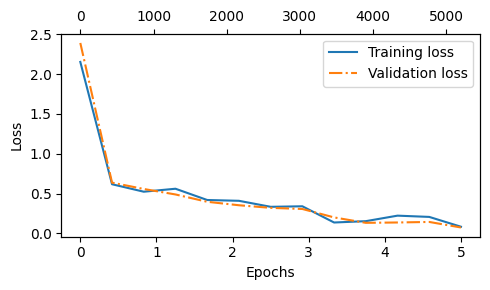

In [41]:
# 创建 x 轴坐标：从 0 到 num_epochs，生成与 train_losses 长度相同的均匀分布点
# 用于在图表中显示"训练轮次(Epochs)"维度
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# 创建第二个 x 轴坐标：从 0 到 examples_seen（已处理的样本总数），生成与 train_losses 长度相同的均匀分布点
# 用于在图表中显示"已处理样本数"维度（通过 twiny 创建的第二个 x 轴）
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

# 调用绘图函数，绘制训练损失和验证损失随训练进度的变化曲线
# - epochs_tensor: 主 x 轴（训练轮次）
# - examples_seen_tensor: 辅助 x 轴（已处理样本数）
# - train_losses: 训练集损失值列表
# - val_losses: 验证集损失值列表
# - 默认 label="loss"，图表标题和 y 轴标签会显示 "loss"
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- 图中, 根据训练的斜率, 我们可以发现模型训练的很好
- 此外, 训练和验证损失非常接近可以表明，该模型不会倾向于过拟合训练数据
- 同样的, 我们可以对精度进行绘制

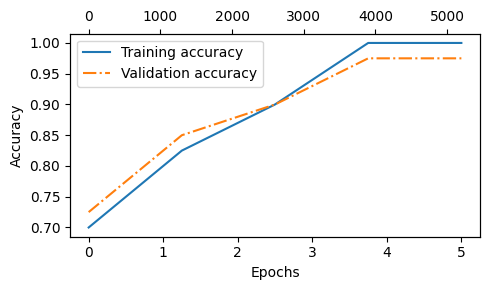

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- 根据上面的准确率图，我们可以看到该模型在第 4 个和第 5 循环之后,训练和验证准确率变得相对较高
- 但是，别忘了我们之前在 training 函数中指定了 `eval_iter=5`，这意味着我们只估计了训练和验证集的性能
- 我们可以计算完整数据集的训练、验证和测试集性能，如下所示

In [43]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")
# 输出总的训练集、验证集和测试集的准确率

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


- 我们可以看到，训练集和验证集的表现实际上是相同的。
- 然而，由于测试集表现略微较差，我们可以看出，模型在一定程度上对训练数据进行了过拟合，同时也对用于调整超参数（如学习率）的验证数据进行了过拟合。
- 不过，这种情况是正常的，并且通过增加模型的 dropout rate（drop_rate）或优化器设置中的 weight_decay，可能进一步减小这种差距。

## 6.8 使用LLM作为垃圾消息分类器

<img src="../image/15.png" width=500px>

- 最后，让我们将微调后的 GPT 模型投入实际应用。
- 以下的 `classify_review` 函数实现了类似于我们之前实现的 `SpamDataset` 的数据预处理步骤。
- 然后，函数返回模型预测的整数类别标签，并返回对应的类别名称。

In [44]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    """
    使用微调后的 GPT 模型对文本进行垃圾消息分类
    
    参数:
        text: 待分类的输入文本字符串
        model: 微调后的 GPT 模型实例
        tokenizer: 用于文本编码的 tokenizer
        device: 运行设备（'cpu' 或 'cuda'）
        max_length: 输入序列的最大长度（默认为 None）
        pad_token_id: 填充 token 的 ID（默认为 50256，GPT-2 的 <|endoftext|> token）
    
    返回:
        字符串 "spam" 或 "not spam"，表示分类结果
    """
    
    # ========== 步骤 1: 设置模型为评估模式 ==========
    model.eval()
    # 将模型设置为评估模式，这会：
    # - 禁用 dropout（训练时用于防止过拟合的随机失活层）
    # - 禁用 batch normalization 的更新（如果有的话）
    # - 确保模型行为与训练时不同，适合推理场景
    
    # ========== 步骤 2: 文本编码（tokenization） ==========
    input_ids = tokenizer.encode(text)
    # 使用 tokenizer 将输入文本转换为 token ID 列表
    # 例如: "Hello world" -> [15496, 995] (具体数字取决于 tokenizer 的词汇表)
    
    # ========== 步骤 3: 获取模型支持的最大上下文长度 ==========
    supported_context_length = model.pos_emb.weight.shape[0]
    # 从模型的位置嵌入层（pos_emb）获取支持的最大序列长度
    # pos_emb.weight 的形状是 [max_context_length, embedding_dim]
    # 因此 shape[0] 就是模型能处理的最大 token 数量
    # 对于 GPT-2 small，这个值通常是 1024
    
    # ========== 步骤 4: 截断过长的序列 ==========
    input_ids = input_ids[:min(max_length, supported_context_length)]
    # 如果 token 序列长度超过以下两者中的较小值，则进行截断：
    # - max_length: 用户指定的最大长度（通常是训练时使用的 max_length）
    # - supported_context_length: 模型架构支持的最大长度
    # 这样可以防止输入超出模型的处理能力
    
    # ========== 步骤 5: 填充序列到固定长度 ==========
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    # 如果序列长度小于 max_length，则在末尾添加填充 token
    # 例如: 如果 input_ids = [15496, 995]，max_length = 5，pad_token_id = 50256
    # 则填充后: [15496, 995, 50256, 50256, 50256]
    # 填充是为了保证批处理时所有样本长度一致（虽然这里是单个样本）
    
    # ========== 步骤 6: 转换为张量并添加 batch 维度 ==========
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) 
    # 1. torch.tensor(input_ids, device=device): 将 Python 列表转换为 PyTorch 张量
    #    并直接放到指定设备上（CPU 或 GPU），避免后续数据传输开销
    # 2. unsqueeze(0): 在第 0 维增加一个维度，将形状从 [seq_len] 变为 [1, seq_len]
    #    这是因为模型期望输入的形状是 [batch_size, seq_len]
    #    即使只有一个样本，也需要 batch 维度
    
    # ========== 步骤 7: 模型推理（前向传播） ==========
    with torch.no_grad():
        # 使用 torch.no_grad() 上下文管理器：
        # - 禁用梯度计算，节省内存和计算资源
        # - 推理时不需要梯度，因为我们不会进行反向传播
        
        logits = model(input_tensor)[:, -1, :] 
        # 1. model(input_tensor): 将输入张量传入模型进行前向传播
        #    输出形状为 [batch_size, seq_len, num_classes]
        #    对于我们的分类任务，num_classes = 2（spam 或 not spam）
        # 
        # 2. [:, -1, :]: 提取最后一个 token 位置的 logits
        #    - 第一个 `:` 表示所有 batch（这里只有 1 个）
        #    - `-1` 表示序列的最后一个位置（因为我们在最后一个 token 后添加了分类头）
        #    - 最后一个 `:` 表示所有类别的 logits
        #    结果形状: [batch_size, num_classes] = [1, 2]
        # 
        # 3. 为什么只取最后一个 token？
        #    在微调时，我们在序列末尾添加了分类头，模型学会了在最后一个位置
        #    输出分类结果。这是 GPT 类模型做分类任务的标准做法。
    
    # ========== 步骤 8: 获取预测类别 ==========
    predicted_label = torch.argmax(logits, dim=-1).item()
    # 1. torch.argmax(logits, dim=-1): 在最后一个维度（类别维度）上找到最大值的索引
    #    - logits 形状是 [1, 2]，包含两个类别的原始分数
    #    - dim=-1 表示在类别维度上操作
    #    - 返回概率最高的类别索引（0 或 1）
    #    结果形状: [1]（一个标量张量）
    # 
    # 2. .item(): 将单元素张量转换为 Python 标量（int 类型）
    #    这样可以在后续的 if 语句中直接使用
    # 
    # 注意: 这里直接用 argmax 而不是先 softmax 再 argmax，因为：
    # - softmax 不会改变最大值的位置
    # - 我们只关心哪个类别概率最高，不需要具体的概率值
    
    # ========== 步骤 9: 返回人类可读的分类结果 ==========
    return "spam" if predicted_label == 1 else "not spam"
    # 将数字标签转换为字符串标签：
    # - 如果预测标签是 1，返回 "spam"（垃圾消息）
    # - 如果预测标签是 0，返回 "not spam"（正常消息）
    # 这个映射关系与训练数据的标签编码一致

- 试一下

In [45]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [46]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


- 最后，让我们保存模型，以便以后如果需要重用模型时，无需重新训练。

In [47]:
torch.save(model.state_dict(), "review_classifier.pth")
# 储存!大功告成!

- 下次我们可以这么唤醒这个模型

In [48]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 总结

- 请参阅 [./gpt_class_finetune.py](./gpt_class_finetune.py) 脚本，这是一个自包含的分类微调脚本。
- 你可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到练习解决方案。
- 此外，感兴趣的读者可以在 [附录E](../../appendix-E) 中找到关于低秩适应（LoRA）的参数高效微调的介绍。